<a href="https://colab.research.google.com/github/Rathachai/semantic-bus-planning/blob/main/semantic-bus-planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling an RDF Knowledge Graph with Transitivity and Symmetry for Bus Route Path Finding



*   **Rathachai Chawuthai**, King Mongkut's Institute of Technology Ladkrabang
*   **Natthawut Kertkeidkachorn**, Japan Advanced Institute of Science and Technology
*   **Teeradaj Racharak**, Japan Advanced Institute of Science and Technology


---




## To Import Libralies

In [1]:
!pip install -q rdflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.7 MB/s eta 0:00:00


In [2]:
!pip install -q owlrl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 576.4 kB/s eta 0:00:00


In [3]:
import rdflib
from rdflib import URIRef, BNode, Literal
from rdflib import Namespace
from rdflib.namespace import CSVW, DC, DCAT, DCTERMS, DOAP, FOAF, ODRL2, ORG, OWL, PROF, PROV, RDF, RDFS, SDO, SH, SKOS, SOSA, SSN, TIME, VOID, XMLNS, XSD
from rdflib.plugins import sparql

import owlrl


## Example Bus Route

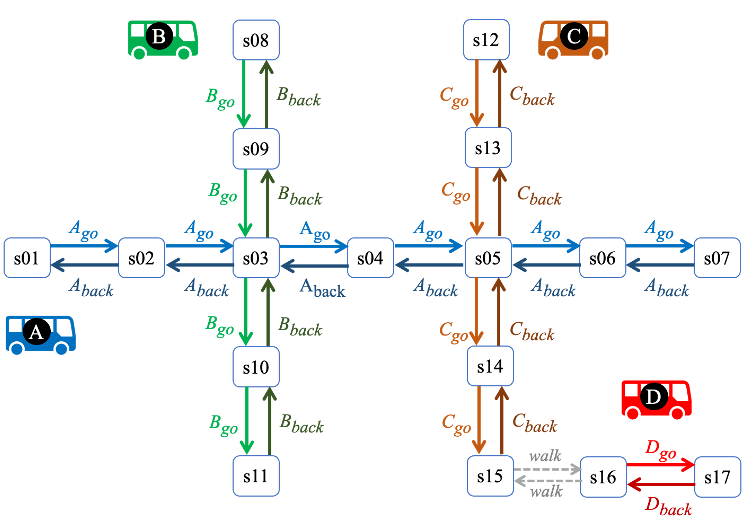

## RDF Data

### Note


---



line:J_g  = Line J direction go

line:J_b  = Line J direction back


---



line:J_gt  = Line J direction go (Transitive)

line:J_bt  = Line J direction back (Transitive)


In [4]:
tbox_text = """

#####################################
##            NAMESPACES           ##
#####################################

@prefix tc: <http://transline.org/terms/> .
@prefix sta: <http://transline.org/stations/> .
@prefix line: <http://transline.org/lines/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .

#####################################
##         TRANSLINE TERMS         ##
#####################################

tc:PlanItem rdfs:label "Plan Item" ;
            rdfs:comment  "Potential Item in a Route Plan" .

tc:walk rdf:type tc:PlanItem, owl:SymmetricProperty ;
        rdfs:label "walk"@en .

#####################################
##      APPLICATION ONTOLOGY       ##
#####################################

line:A_gt rdf:type tc:PlanItem, owl:TransitiveProperty .
line:A_bt rdf:type tc:PlanItem, owl:TransitiveProperty .
line:B_gt rdf:type tc:PlanItem, owl:TransitiveProperty .
line:B_bt rdf:type tc:PlanItem, owl:TransitiveProperty .
line:C_gt rdf:type tc:PlanItem, owl:TransitiveProperty .
line:C_bt rdf:type tc:PlanItem, owl:TransitiveProperty .
line:D_gt rdf:type tc:PlanItem, owl:TransitiveProperty .
line:D_bt rdf:type tc:PlanItem, owl:TransitiveProperty .

line:A_g rdfs:subPropertyOf line:A_gt .
line:A_b rdfs:subPropertyOf line:A_bt .

line:B_g rdfs:subPropertyOf line:B_gt .
line:B_b rdfs:subPropertyOf line:B_bt .

line:C_g rdfs:subPropertyOf line:C_gt .
line:C_b rdfs:subPropertyOf line:C_bt .

line:D_g rdfs:subPropertyOf line:D_gt .
line:D_b rdfs:subPropertyOf line:D_bt .

"""

In [5]:
abox_text = """
@prefix tc: <http://transline.org/terms/> .
@prefix sta: <http://transline.org/stations/> .
@prefix line: <http://transline.org/lines/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .

#####################################
##    INSTANCE KNOWLEDGE GRAPH     ##
#####################################

sta:s01  line:A_g sta:s02 .
sta:s02  line:A_g sta:s03 .
sta:s03  line:A_g sta:s04 .
sta:s04  line:A_g sta:s05 .
sta:s05  line:A_g sta:s06 .
sta:s06  line:A_g sta:s07 .

sta:s07  line:A_b sta:s06 .
sta:s06  line:A_b sta:s05 .
sta:s05  line:A_b sta:s04 .
sta:s04  line:A_b sta:s03 .
sta:s03  line:A_b sta:s02 .
sta:s02  line:A_b sta:s01 .

sta:s08  line:B_g sta:s09 .
sta:s09  line:B_g sta:s03 .
sta:s03  line:B_g sta:s10 .
sta:s10  line:B_g sta:s11 .

sta:s11  line:B_b sta:s10 .
sta:s10  line:B_b sta:s03 .
sta:s03  line:B_b sta:s09 .
sta:s09  line:B_b sta:s08 .

sta:s12  line:C_g sta:s13 .
sta:s13  line:C_g sta:s05 .
sta:s05  line:C_g sta:s14 .
sta:s14  line:C_g sta:s15 .

sta:s15  line:C_b sta:s14 .
sta:s14  line:C_b sta:s05 .
sta:s05  line:C_b sta:s13 .
sta:s13  line:C_b sta:s12 .

sta:s15  tc:walk  sta:s16 .

sta:s16  line:D_g sta:s17 .
sta:s17  line:D_b sta:s16 .
"""

In [6]:
g_tbox = rdflib.Graph().parse( data=tbox_text, format='turtle' )

In [7]:
g_abox = rdflib.Graph().parse( data=abox_text, format='turtle' )

In [8]:
g = g_tbox + g_abox

## RDFS and OWL Reasoning

In [9]:
#owlrl.DeductiveClosure(owlrl.RDFS_Semantics, datatype_axioms=True).expand(g)
#owlrl.DeductiveClosure(owlrl.OWLRL_Extension, datatype_axioms=True).expand(g)
owlrl.DeductiveClosure(owlrl.OWLRL_Extension, rdfs_closure = True).expand(g)

In [10]:
#save
#g.serialize(destination="bus-graph.ttl")


## SPARQL

In [11]:
initNs={
    "rdf":RDF,
    "rdfs":RDFS,
    "tc":"http://transline.org/terms/",
    "sta":"http://transline.org/stations/",
    "line":"http://transline.org/lines/"
    }

### Query with 1 hop

In [12]:
spql = """
  SELECT DISTINCT ?p1
  WHERE {
    sta:s01 ?p1 sta:s06 .
    ?p1 rdf:type tc:PlanItem .
  }
"""

res = g.query(spql, initNs=initNs)

for row in res:
  print(row)

(rdflib.term.URIRef('http://transline.org/lines/A_gt'),)


In [13]:
spql = """
  SELECT DISTINCT ?p1 ?x1 ?p2
  WHERE {
    sta:s01 ?p1 ?x1 . ?x1 ?p2  sta:s08 .
    ?p1 rdf:type tc:PlanItem .
    ?p2 rdf:type tc:PlanItem .

    FILTER ((?p1 != ?p2))
  }
"""

res = g.query(spql, initNs=initNs)

for row in res:
  print(row)

(rdflib.term.URIRef('http://transline.org/lines/A_gt'), rdflib.term.URIRef('http://transline.org/stations/s03'), rdflib.term.URIRef('http://transline.org/lines/B_bt'))


### Query with 2 hops

In [14]:
spql = """
  SELECT DISTINCT ?p1 ?x1 ?p2 ?x2 ?p3
  WHERE {
    sta:s08 ?p1 ?x1 . ?x1 ?p2 ?x2 . ?x2 ?p3  sta:s15 .
    ?p1 rdf:type tc:PlanItem .
    ?p2 rdf:type tc:PlanItem .
    ?p3 rdf:type tc:PlanItem .

    FILTER ((?p1 != ?p2) && (?p2 != ?p3))

  }
"""

res = g.query(spql, initNs=initNs)

for row in res:
  print(row)

(rdflib.term.URIRef('http://transline.org/lines/B_gt'), rdflib.term.URIRef('http://transline.org/stations/s03'), rdflib.term.URIRef('http://transline.org/lines/A_gt'), rdflib.term.URIRef('http://transline.org/stations/s05'), rdflib.term.URIRef('http://transline.org/lines/C_gt'))


### Query with 3 hops

In [15]:
spql = """
  SELECT DISTINCT ?p1 ?x1 ?p2 ?x2 ?p3 ?x3 ?p4
  WHERE {
    sta:s01 ?p1 ?x1 . ?x1 ?p2 ?x2 . ?x2 ?p3 ?x3 . ?x3 ?p4  sta:s17 .
    ?p1 rdf:type tc:PlanItem .
    ?p2 rdf:type tc:PlanItem .
    ?p3 rdf:type tc:PlanItem .
    ?p4 rdf:type tc:PlanItem .

    FILTER ((?p1 != ?p2) && (?p2 != ?p3) && (?p3 != ?p4))

  }
"""

res = g.query(spql, initNs=initNs)

for row in res:
  print(row)

(rdflib.term.URIRef('http://transline.org/lines/A_gt'), rdflib.term.URIRef('http://transline.org/stations/s05'), rdflib.term.URIRef('http://transline.org/lines/C_gt'), rdflib.term.URIRef('http://transline.org/stations/s15'), rdflib.term.URIRef('http://transline.org/terms/walk'), rdflib.term.URIRef('http://transline.org/stations/s16'), rdflib.term.URIRef('http://transline.org/lines/D_gt'))



---


## Funtion Generateing a SPARQL Statement
(is not tested)

In [16]:
# Function Generate a SPARQL Statment

def gen_sparql(src="", des="", num_lines=1, show_stations=False):
  con1 = f" {src} "
  con2 = ""
  select = ""
  con3 = ""
  con3_list = []

  i=1
  for i in range(1, num_lines+1):
    pi = f"?p{i}"
    xi = f"?x{i}"

    #select statement
    select += f" {pi} "
    if i < num_lines:
       select += f" {xi} " if show_stations else ""

    #chain of p
    if i < num_lines:
      con1 += f" {pi} {xi} . {xi} "

      # pi != pi+1
      pj = f"?p{i+1}"
      con3_list.append(f" ({pi} != {pj}) ")

    #p in plan item
    con2 += f" {pi} rdf:type tc:PlanItem . "

  #final hop
  con1 += f" {pi} {des} . "

  #filter condition
  if len(con3_list)>0 :
    con3 = " FILTER (" + " && ".join(con3_list) + " ) "

  return "SELECT DISTINCT " + select + " WHERE { " + con1 + con2 + con3 + " } "

In [17]:
gen_sparql("sta:s01", "sta:s17", 4, True)

'SELECT DISTINCT  ?p1  ?x1  ?p2  ?x2  ?p3  ?x3  ?p4  WHERE {  sta:s01  ?p1 ?x1 . ?x1  ?p2 ?x2 . ?x2  ?p3 ?x3 . ?x3  ?p4 sta:s17 .  ?p1 rdf:type tc:PlanItem .  ?p2 rdf:type tc:PlanItem .  ?p3 rdf:type tc:PlanItem .  ?p4 rdf:type tc:PlanItem .  FILTER ( (?p1 != ?p2)  &&  (?p2 != ?p3)  &&  (?p3 != ?p4)  )  } '

In [18]:
spql = gen_sparql("sta:s01", "sta:s17", 6, False)
print(spql)

res = g.query(spql, initNs=initNs)

for row in res:
  print(row)

SELECT DISTINCT  ?p1  ?p2  ?p3  ?p4  ?p5  ?p6  WHERE {  sta:s01  ?p1 ?x1 . ?x1  ?p2 ?x2 . ?x2  ?p3 ?x3 . ?x3  ?p4 ?x4 . ?x4  ?p5 ?x5 . ?x5  ?p6 sta:s17 .  ?p1 rdf:type tc:PlanItem .  ?p2 rdf:type tc:PlanItem .  ?p3 rdf:type tc:PlanItem .  ?p4 rdf:type tc:PlanItem .  ?p5 rdf:type tc:PlanItem .  ?p6 rdf:type tc:PlanItem .  FILTER ( (?p1 != ?p2)  &&  (?p2 != ?p3)  &&  (?p3 != ?p4)  &&  (?p4 != ?p5)  &&  (?p5 != ?p6)  )  } 
(rdflib.term.URIRef('http://transline.org/lines/A_gt'), rdflib.term.URIRef('http://transline.org/lines/C_gt'), rdflib.term.URIRef('http://transline.org/terms/walk'), rdflib.term.URIRef('http://transline.org/lines/D_gt'), rdflib.term.URIRef('http://transline.org/lines/D_bt'), rdflib.term.URIRef('http://transline.org/lines/D_gt'))
(rdflib.term.URIRef('http://transline.org/lines/A_gt'), rdflib.term.URIRef('http://transline.org/lines/C_gt'), rdflib.term.URIRef('http://transline.org/lines/C_bt'), rdflib.term.URIRef('http://transline.org/lines/C_gt'), rdflib.term.URIRef('http

---
## つづく
